# Stochastic Volatility model

In [1]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy.sparse import csc_matrix
from scipy import optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [2]:
n = 400
returns = np.genfromtxt("../data/SP500.csv")[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

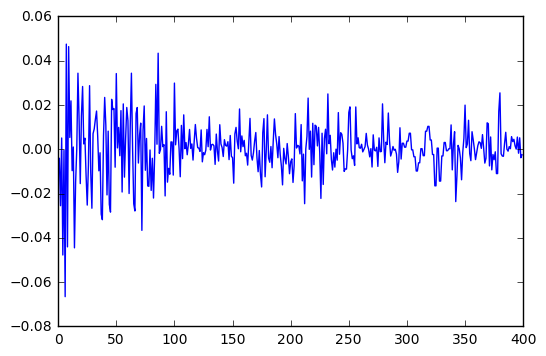

In [3]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [5]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.StudentT('r', nu, lam=pm.math.exp(-2*s), observed=returns)

Applied log-transform to sigma and added transformed sigma_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. However, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect to the volatility process, 's', keeping `log_sigma` and `nu` constant at their default values. 

We use L-BFGS because it is more efficient for high dimensional functions (`s` has n elements).

In [6]:
with model:
    mu, sds, elbo = pm.variational.advi(n=200000)

Iteration 0 [0%]: ELBO = -78112.89
Iteration 20000 [10%]: Average ELBO = -13980.82
Iteration 40000 [20%]: Average ELBO = 369.75
Iteration 60000 [30%]: Average ELBO = 1008.15
Iteration 80000 [40%]: Average ELBO = 1133.24
Iteration 100000 [50%]: Average ELBO = 1138.86
Iteration 120000 [60%]: Average ELBO = 1138.72
Iteration 140000 [70%]: Average ELBO = 1138.76
Iteration 160000 [80%]: Average ELBO = 1138.73
Iteration 180000 [90%]: Average ELBO = 1138.6
Finished [100%]: Average ELBO = 1138.44


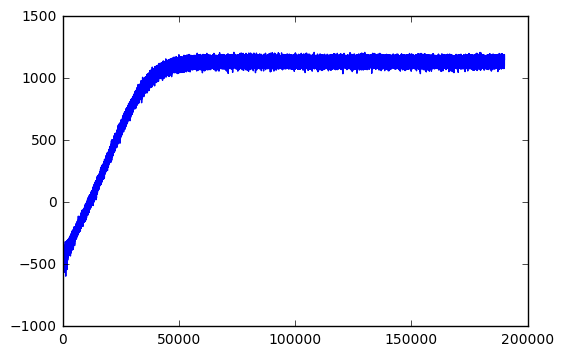

In [7]:
plt.plot(elbo[10000:])

We do a short initial run to get near the right area, then start again using a new Hessian at the new starting point to get faster sampling due to better scaling. We do a short run since this is an interactive example.

In [8]:
with model:
    # Start next run at the last sampled position.
    step = pm.NUTS(scaling=model.dict_to_array(sds)**2, is_cov=True)
    trace = pm.sample(2000, step, start=mu)

100%|██████████| 2000/2000 [02:23<00:00,  8.69it/s]


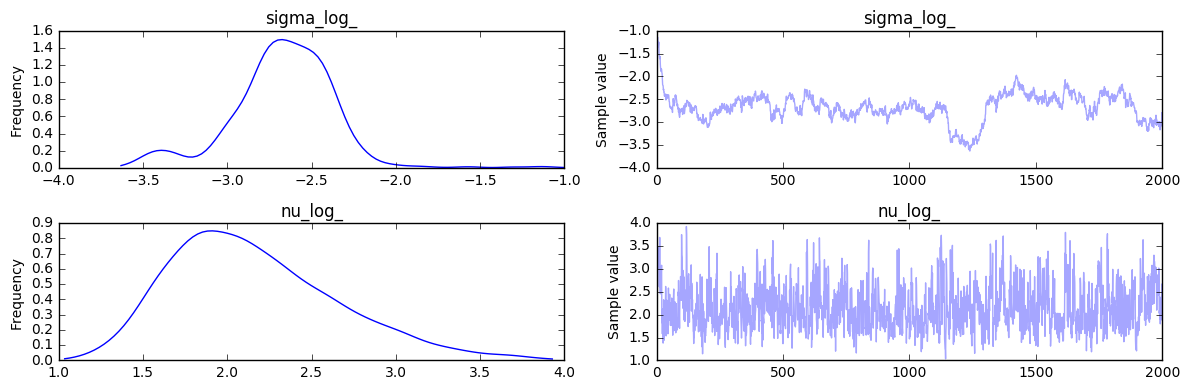

In [9]:
figsize(12,6)
pm.traceplot(trace, model.vars[:-1]);

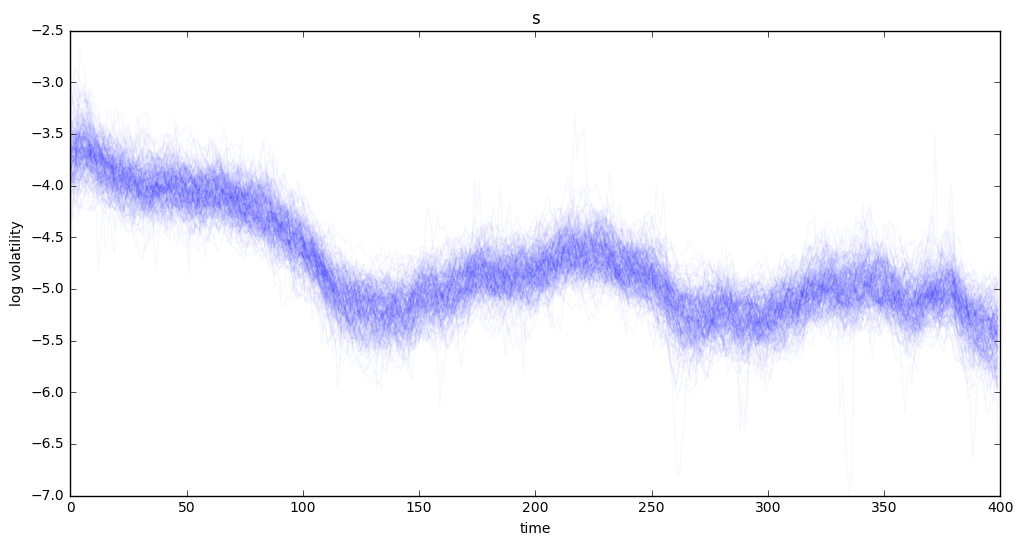

In [10]:
figsize(12,6)
title(str(s))
plot(trace[s][::10].T,'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

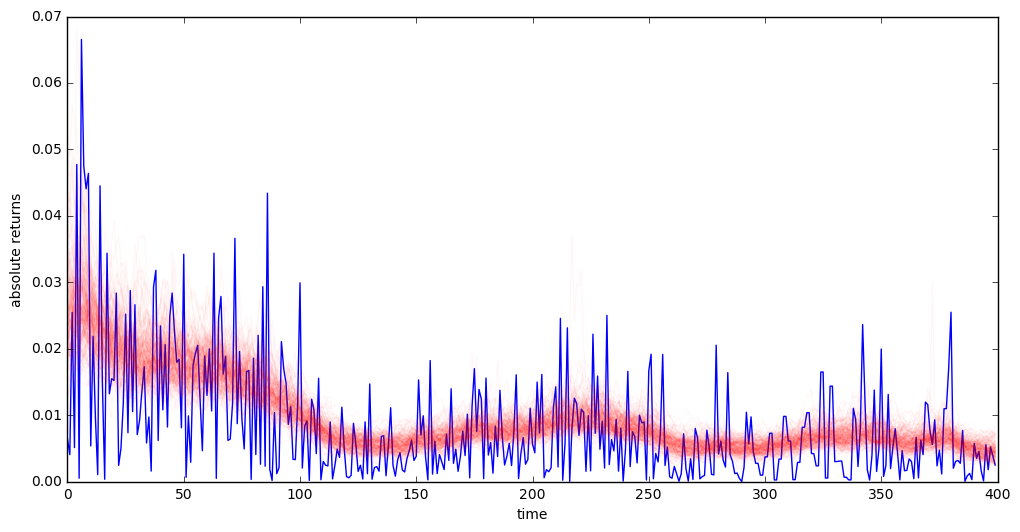

In [14]:
plot(np.abs(returns))
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
xlabel('time')
ylabel('absolute returns')

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 